In [1]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
import math
import copy as cp
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import catboost as cbt
from sklearn.metrics import accuracy_score, roc_auc_score,log_loss
import gc
import math
import time
from tqdm import tqdm
import datetime
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from datetime import datetime,timedelta
import warnings
import os
import statsmodels.api as sm
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from sklearn.model_selection import train_test_split
import copy as cp
import xgboost as xgb
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [2]:
train = pd.read_csv("D:\\data\\second_round_training_data.csv")
test = pd.read_csv("D:\\data\\second_round_testing_data.csv")
submit = pd.read_csv("D:\\data\\submit_example1.csv")

In [3]:
train. head()#显示前五行

,Parameter1,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9,Parameter10,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Quality_label
0,0.167898,104.443982,2.772825,0.146548,0.000421,0.000612,2286.523413,0.035407,0.593081,1.010385,0.323881,2.597820,41.506485,36.955992,8.454598,11.438066,177.243120,338.729256,2.021704,0.079526,Pass
1,252.483066,0.343232,0.066873,0.002495,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,0.004594,0.004243,0.135967,225.632949,0.481860,20597.447822,3.723330,15.376190,0.986973,4.634376,Fail
2,4.124654,0.170534,0.383800,0.000004,0.000909,0.001972,2286.523413,0.035407,0.593081,1.010385,0.031295,0.951186,0.000423,2.208138,0.073525,236.079314,0.064196,0.576302,33.875790,1.813727,Fail
3,294.656750,6.153711,0.014716,4284.326273,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,1.480634,0.000122,0.000084,0.654517,0.025872,176.948915,0.029777,0.246726,27.117165,0.081819,Fail
4,0.026284,0.166810,7.587398,0.002202,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,867.342323,0.827308,0.040846,0.260989,0.009380,194.798039,0.055053,0.014725,13.569707,18.138496,Fail


In [4]:
test. head()#显示前五行

,Group,Parameter1,Parameter10,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9
0,0,2.167762,10.060093,0.035811,0.459938,7.460600,17.962176,18.872982,0.152059,0.035407,0.593081
1,0,0.006197,0.052625,0.047829,0.322457,0.207077,0.664442,0.314162,0.038483,17.850021,0.593081
2,0,1.179951,0.052625,0.075537,26.113194,0.304415,0.664442,0.258497,0.038483,17.850021,0.593081
3,0,0.007218,1.010385,5.081092,1.132919,931.721241,2.225808,2.208755,0.038483,2.931083,NaN
4,0,3.355337,0.377332,0.076572,23.199547,1.172201,3.095123,2.684398,0.038483,2.931083,NaN


In [5]:
train.isnull().sum()#对所有列判断是否有空，然后再统计个数

Parameter1       0
Parameter2       0
Parameter3       0
Parameter4       0
Parameter5       0
Parameter6       0
Parameter7       0
Parameter8       0
Parameter9       0
Parameter10      0
Attribute1       0
Attribute2       0
Attribute3       0
Attribute4       0
Attribute5       0
Attribute6       0
Attribute7       0
Attribute8       0
Attribute9       0
Attribute10      0
Quality_label    0
dtype: int64

In [6]:
#查看数据大小
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12934 entries, 0 to 12933
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Parameter1     12934 non-null  float64
 1   Parameter2     12934 non-null  float64
 2   Parameter3     12934 non-null  float64
 3   Parameter4     12934 non-null  float64
 4   Parameter5     12934 non-null  float64
 5   Parameter6     12934 non-null  float64
 6   Parameter7     12934 non-null  float64
 7   Parameter8     12934 non-null  float64
 8   Parameter9     12934 non-null  float64
 9   Parameter10    12934 non-null  float64
 10  Attribute1     12934 non-null  float64
 11  Attribute2     12934 non-null  float64
 12  Attribute3     12934 non-null  float64
 13  Attribute4     12934 non-null  float64
 14  Attribute5     12934 non-null  float64
 15  Attribute6     12934 non-null  float64
 16  Attribute7     12934 non-null  float64
 17  Attribute8     12934 non-null  float64
 18  Attrib

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Group        6000 non-null   int64  
 1   Parameter1   6000 non-null   float64
 2   Parameter10  6000 non-null   float64
 3   Parameter2   6000 non-null   float64
 4   Parameter3   6000 non-null   float64
 5   Parameter4   6000 non-null   float64
 6   Parameter5   6000 non-null   float64
 7   Parameter6   6000 non-null   float64
 8   Parameter7   6000 non-null   float64
 9   Parameter8   6000 non-null   float64
 10  Parameter9   3000 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 515.8 KB


In [8]:
col = train[['Parameter1','Parameter2','Parameter3','Parameter4','Parameter5','Parameter6','Parameter7','Parameter8','Parameter9','Parameter10']]
col_na=col.corr()

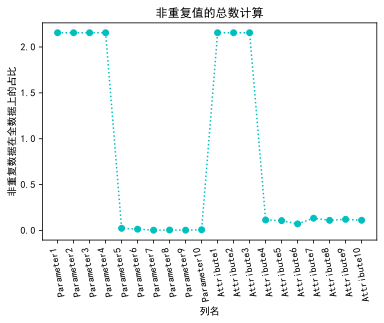

In [9]:
#数据离散性和连续性分析
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

col_name = train.drop(['Quality_label'], 1).columns
Notdlts_count = []
for i in col_name:
    # 计算非重复值的个数
    Notdlts = len(train[i].drop_duplicates()) / 6000  # 如果没有重复的 计算结果是1 有重复的结果就不是1 比1小
    Notdlts_count.append(Notdlts)

plt.plot(col_name, Notdlts_count, c='c',marker="o",linestyle=":")
plt.title('非重复值的总数计算')  # 标题
plt.xlabel('列名')  # x轴 的轴名
plt.ylabel('非重复数据在全数据上的占比')  # y轴 的轴名
plt.xticks(rotation=100)  # 旋转 x轴的刻度名
#plt.savefig('%s 离散分析.jpg'%i)
plt.show()

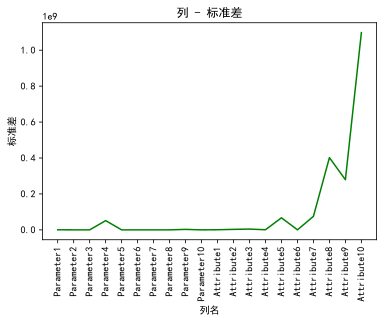

In [10]:

# 计算 标准差(std)
col_std = train.describe().T['std']
    
plt.plot(col_name, col_std, c='g')  # 作图
plt.title('列 - 标准差')     # 标题
plt.xlabel('列名')           # x轴 的轴名
plt.ylabel('标准差')         # y轴 的轴名
plt.xticks(rotation=90)      # 旋转 x轴的刻度名
#plt.savefig('%s 离散分析.jpg'%i, dpi=500, bbox_inches='tight') # 解决图片不清晰，不完整的问题

plt.show()


In [ ]:
#分析前
# 遍历列名
for i in col_name:
    plt.hist(train[i],bins=20)
    plt.title('%s 平均分割取值范围计数统计图'%i)
    plt.xlabel('%s范围'%i)
    plt.ylabel('值在该范围的个数')
    #plt.savefig('%s 平均分割取值范围计数统计图.jpg'%i, dpi=500, bbox_inches='tight') # 解决图片不清晰，不完整的问题
    plt.show()

In [12]:
lb = LabelEncoder()
train["Quality_label"] = lb.fit_transform(train["Quality_label"])

In [ ]:
#去偏结果
train[col_name] = train[col_name]**(1/4)
# 遍历列名
for i in col_name:
    sns.distplot(train[i], bins=20)
    plt.title('%s 平均分割取值范围计数统计图'%i)
    plt.xlabel('%s范围'%i)
    plt.ylabel('值在该范围的个数')
    #plt.savefig('%s 平均分割取值范围计数统计图.jpg'%i, dpi=500, bbox_inches='tight') # 解决图片不清晰，不完整的问题
    plt.show()


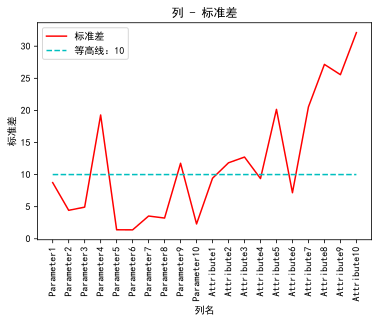

In [15]:
# 此处选择 开4次方 (一般在2-10之间)
plt.plot(col_name, col_std**(1/6), c='r')  # 作图
plt.plot(col_name, 10*np.ones((1,20))[0], c='c', linestyle="--")
plt.title('列 - 标准差')     # 标题
plt.xlabel('列名')           # x轴 的轴名
plt.ylabel('标准差')         # y轴 的轴名
plt.xticks(rotation=90)      # 旋转 x轴的刻度名
plt.legend(['标准差','等高线：10'])
plt.show()

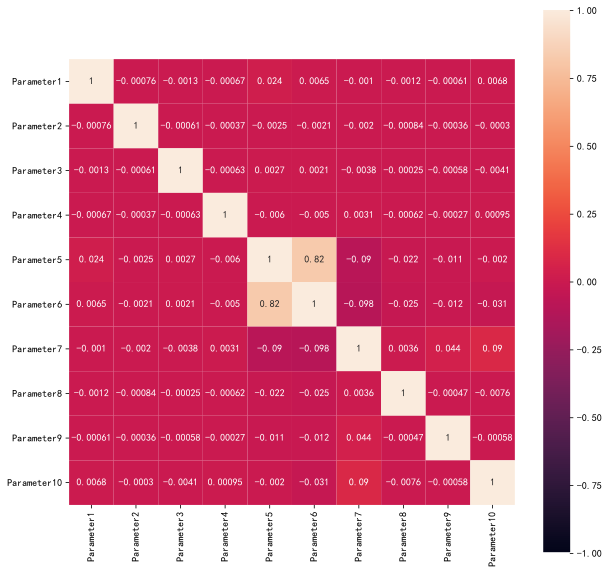

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mask = np.zeros_like(col_na)
mask[np.triu_indices_from(mask)] = True
plt.rcParams['font.sans-serif']=['SimHei']
fig = plt.figure(figsize=(10,10))
sns.heatmap(col_na,square=True,vmax=1, vmin=-1,annot=True)
#plt.savefig('相关性热力图.jpg',dpi=500, bbox_inches='tight')
plt.show()

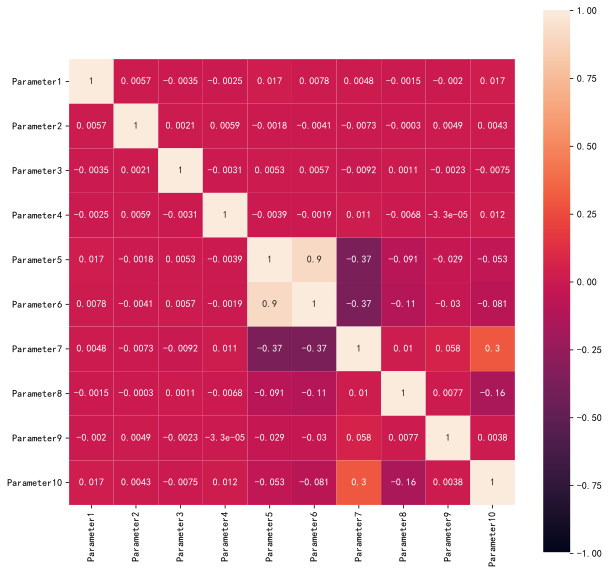

In [17]:
col_name= col**(1/2)
col_name1=col_name.corr()
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mask = np.zeros_like(col_name1)
mask[np.triu_indices_from(mask)] = True
plt.rcParams['font.sans-serif']=['SimHei']
fig = plt.figure(figsize=(10,10))
sns.heatmap(col_name1,square=True,vmax=1, vmin=-1,annot=True)
#plt.savefig('相关性热力图1.jpg',dpi=500, bbox_inches='tight')
plt.show()